In [88]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 16)
import seaborn as sns
import datetime
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
def import_files(path):
    file_dfs = {}
    for subject_ID in os.listdir(f"{path}"):
        df = pd.read_csv(f"{path}/{subject_ID}/glucose.csv")
        join_date_time(df, "date", "time")
        df.index = pd.to_datetime(df.datetime)
        df.drop(columns=["comments","datetime"],inplace=True)
        file_dfs[f"{subject_ID}"] = df

    return file_dfs

In [3]:
def import_food_files(path):
    file_dfs = {}
    for subject_ID in os.listdir(f"{path}"):
        df = pd.read_csv(f"{path}/{subject_ID}/food.csv")
        process_food_file(df)
        df.index = pd.to_datetime(df.datetime)
        file_dfs[f"{subject_ID}"] = df

    return file_dfs

In [4]:
def process_food_file(df):
    
    """
    This loads in each food file for each unique subject and processes it.
    
    First I will join date and time into one column.
    Since I don't plan on using computer vision I will drop the picture column.
    
    Then I will fix mistakes in the data entry.
    Mainly in the columns:
        1. balance
        2. quality
        3. calories
    """
    # Only health subjects contain the date and time columns.
    
    try:
        join_date_time(df, "date", "time")
    except KeyError:
        pass
    
    df.drop(columns=["picture","description"],inplace=True)
    
    if '8 Balance""' in df["balance"]:
        df.replace('8 Balance""', "Balance",inplace=True)
    
    df.replace('No information', np.nan,inplace=True)
    
    if df["calories"].dtypes == object:
        find_correct_calorie_column(df)
        
def find_correct_calorie_column(df):
    
    for i, value in enumerate(df["calories"]):   
        if type(value) != float: # This should filter out all Null values
            try:
                df["calories"][i] = int(value)
            except ValueError:
                if value in ["Balance","Unbalance"]:
                    df["balance"][i] = value
                elif value in ['Good quality', 'Medium quality', 'Low quality']:
                    df["quality"][i] = value
                df["calories"][i] = np.nan

In [5]:
def join_date_time(df, date_col, time_col):
    new_df = pd.to_datetime(df[date_col].astype(str) + ' ' +df[time_col].astype(str))
    df.insert(2, 'datetime', new_df)
    df.drop(columns=[date_col, time_col],inplace=True)   

In [6]:
pd.read_csv("data/D1NAMO/healthy_subset/001/food.csv")

,date,time,picture,description,calories,balance,quality
0,2014-10-01,12:58,000.jpg,"Tortelliniswith cheese,salad and Kagi chocolate",770.0,Unbalance,Medium quality
1,2014-10-01,15:30,NaN,Yogourt + chocolate bar,NaN,NaN,NaN
2,2014-10-01,18:11,001.jpg,"Champignon pizza, beet steamed, pear and grapes",926.0,Unbalance,Good quality
3,2014-10-01,22:00,NaN,Yogourt,NaN,NaN,NaN
4,2014-10-02,07:33,002.jpg,"Toast with mermelade,croissant with chocolate,...",689.0,Balance,Medium quality
5,2014-10-02,09:28,NaN,Coffee + chocolate bar,NaN,NaN,NaN
6,2014-10-02,12:06,003.jpg,"Pasta with meat loaf, endives, kiwi and plum",612.0,Unbalance,Good quality
7,2014-10-02,18:00,NaN,Beer tasting,NaN,NaN,NaN
8,2014-10-02,20:03,004.jpg,"Fondue,meat,Raw beef onions and cucumber, bread",1697.0,Unbalance,Good quality
9,2014-10-03,08:10,005.jpg,"Nutella pie, orange juice, coffee and mandarine",874.0,Unbalance,Medium quality


In [7]:
path = "data/D1NAMO/healthy_subset"
glucose = import_files(path)

In [8]:
food = import_food_files(path)
food["017"]= food["017"].replace({'8 Balance""':"Balance"}) 

C:\Users\PC\AppData\Local\Temp\ipykernel_13832\927404671.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = int(value)
C:\Users\PC\AppData\Local\Temp\ipykernel_13832\927404671.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = np.nan
C:\Users\PC\AppData\Local\Temp\ipykernel_13832\927404671.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["calories"][i] = int(value)
C:\Users\PC\AppData\

In [9]:
for key in food:
    test_df = food[key].drop(columns=["datetime"])
    test_df["balance"].replace({"Balance":1, "Unbalance":0}, inplace=True)
    test_df["quality"].replace({"Medium quality":2, "Good quality":3, "Low quality":0}, inplace=True)
    try:
        b_mode = test_df["balance"].mean()
        q_mode = test_df["quality"].mean()
    except:
        print(test_df)
    c_mean = test_df["calories"].mean()

    test_df["calories"].fillna(c_mean,inplace=True)
    test_df["balance"].fillna(b_mode,inplace=True)
    test_df["quality"].fillna(q_mode,inplace=True)
    
    food[key] = test_df

In [10]:
food["001"]

,calories,balance,quality
datetime,,,
2014-10-01 12:58:00,770.000000,0.000000,2.000000
2014-10-01 15:30:00,687.307692,0.384615,2.615385
2014-10-01 18:11:00,926.000000,0.000000,3.000000
2014-10-01 22:00:00,687.307692,0.384615,2.615385
2014-10-02 07:33:00,689.000000,1.000000,2.000000
2014-10-02 09:28:00,687.307692,0.384615,2.615385
2014-10-02 12:06:00,612.000000,0.000000,3.000000
2014-10-02 18:00:00,687.307692,0.384615,2.615385
2014-10-02 20:03:00,1697.000000,0.000000,3.000000


In [11]:
glucose["001"]

,glucose,type
datetime,,
2014-10-01 11:35:00,4.4,BL
2014-10-01 15:23:00,5.7,AL
2014-10-01 18:00:00,3.2,BD
2014-10-01 20:07:00,6.6,AD
2014-10-02 07:15:00,5.7,BB
2014-10-02 09:32:00,6.1,AB
2014-10-02 12:00:00,5.1,BL
2014-10-02 14:30:00,5.7,AL
2014-10-02 19:45:00,5.3,BD


In [12]:
for key in glucose:
    glucose[key]["type"]

In [13]:
glucose["014"][1:].sort_index()

,glucose,type
datetime,,
2014-10-01 12:08:00,4.5,BL
2014-10-01 14:27:00,5.3,AL
2014-10-01 18:50:00,4.8,BD
2014-10-01 21:15:00,7.4,AD
2014-10-02 08:59:00,4.8,BB
2014-10-02 10:59:00,4.5,AB
2014-10-02 12:06:00,4.8,BL
2014-10-02 14:20:00,6.0,AL
2014-10-02 18:40:00,5.5,BD


In [50]:
new_dict = {}
for key in glucose:
    if key != "012_diabetes":
        glucose[key] = glucose[key].replace({"7:0":"7.0"})
        glucose[key]= glucose[key].dropna().drop_duplicates()
        glucose[key]= glucose[key].sort_index()
        food[key]= food[key].dropna().drop_duplicates()
        food[key]= food[key].sort_index()

        new_dict[key] = glucose[key].join(food[key], how="outer")

In [51]:
meal_glucose_dict = {"prior_glucose":[], 
                     "calories":[], 
                     "mean_balance":[],
                    "mean_quality":[], 
                    "meal":[], 
                    "post_glucose":[],}
for key in new_dict:
    i = 0
    while i < len(new_dict[key]): 
        if pd.notna(new_dict[key]["type"][i]) and new_dict[key]["type"][i][0] == "A" and i > 0:
            # Here I want to sum up all the calories, mean the balance and quality
            meal = new_dict[key]["type"][i][1]
            count = 0
            total_calories = 0
            total_balance = 0
            total_quality = 0
            j = i -1
            while j >= 0:
                if pd.isna(new_dict[key]["type"][j]):
                    count += 1
                    total_calories += new_dict[key]["calories"][j]
                    total_balance += new_dict[key]["balance"][j]
                    total_quality += new_dict[key]["quality"][j]
                elif pd.notna(new_dict[key]["type"][j]):
                    prior_glucose = new_dict[key]["glucose"][j]
                    j = 0
                j -= 1
            if count > 0: 
                meal_glucose_dict["prior_glucose"].append(prior_glucose)
                meal_glucose_dict["calories"].append(total_calories)
                meal_glucose_dict["mean_balance"].append(total_balance/count)
                meal_glucose_dict["mean_quality"].append(total_quality/count)
                meal_glucose_dict["meal"].append(meal)
                meal_glucose_dict["post_glucose"].append(new_dict[key]["glucose"][i])
        i+=1

In [71]:
X = pd.get_dummies(data= pd.DataFrame(meal_glucose_dict), columns=["meal"]).drop(columns=["post_glucose"])
X["prior_glucose"]= X["prior_glucose"].astype(float)
y = pd.DataFrame(meal_glucose_dict)[["post_glucose"]]
y["post_glucose"]= y["post_glucose"].astype(float)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1)

In [38]:
import sys
print(sys.executable)

C:\Users\PC\anaconda3\envs\CA4016\python.exe


In [73]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 102 to 37
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_glucose  110 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [83]:
X.describe()

,prior_glucose,calories,mean_balance,mean_quality,meal_B,meal_D,meal_L
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,5.342029,774.695213,0.269505,2.213428,0.224638,0.369565,0.405797
std,0.745577,791.450275,0.426961,0.907979,0.418864,0.484445,0.492835
min,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.900000,397.750000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,5.300000,605.500000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,5.600000,1000.000000,0.500000,3.000000,0.000000,1.000000,1.000000
max,9.000000,8430.000000,1.000000,3.000000,1.000000,1.000000,1.000000


In [113]:
clf = RandomForestRegressor(random_state=0)
clf = clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")

C:\Users\PC\AppData\Local\Temp\ipykernel_13832\542458575.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train, y_train)
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed wh

In [117]:
print(f"Mean Absolute Percentage Error {(scores.mean()*-100):.2f}%")

Mean Absolute Percentage Error 12.88%


In [114]:
print(f"Negative Mean Absolute Error of {np.abs(scores.mean())}")

Negative Mean Absolute Error of 0.12882583993627636


In [118]:
from sklearn.metrics import mean_absolute_percentage_error

In [105]:
y_hat = clf.predict(X_test)

In [119]:
y_hat = clf.predict(X_test)
score = mean_absolute_percentage_error(y_test, y_hat)

0.14932770936205447

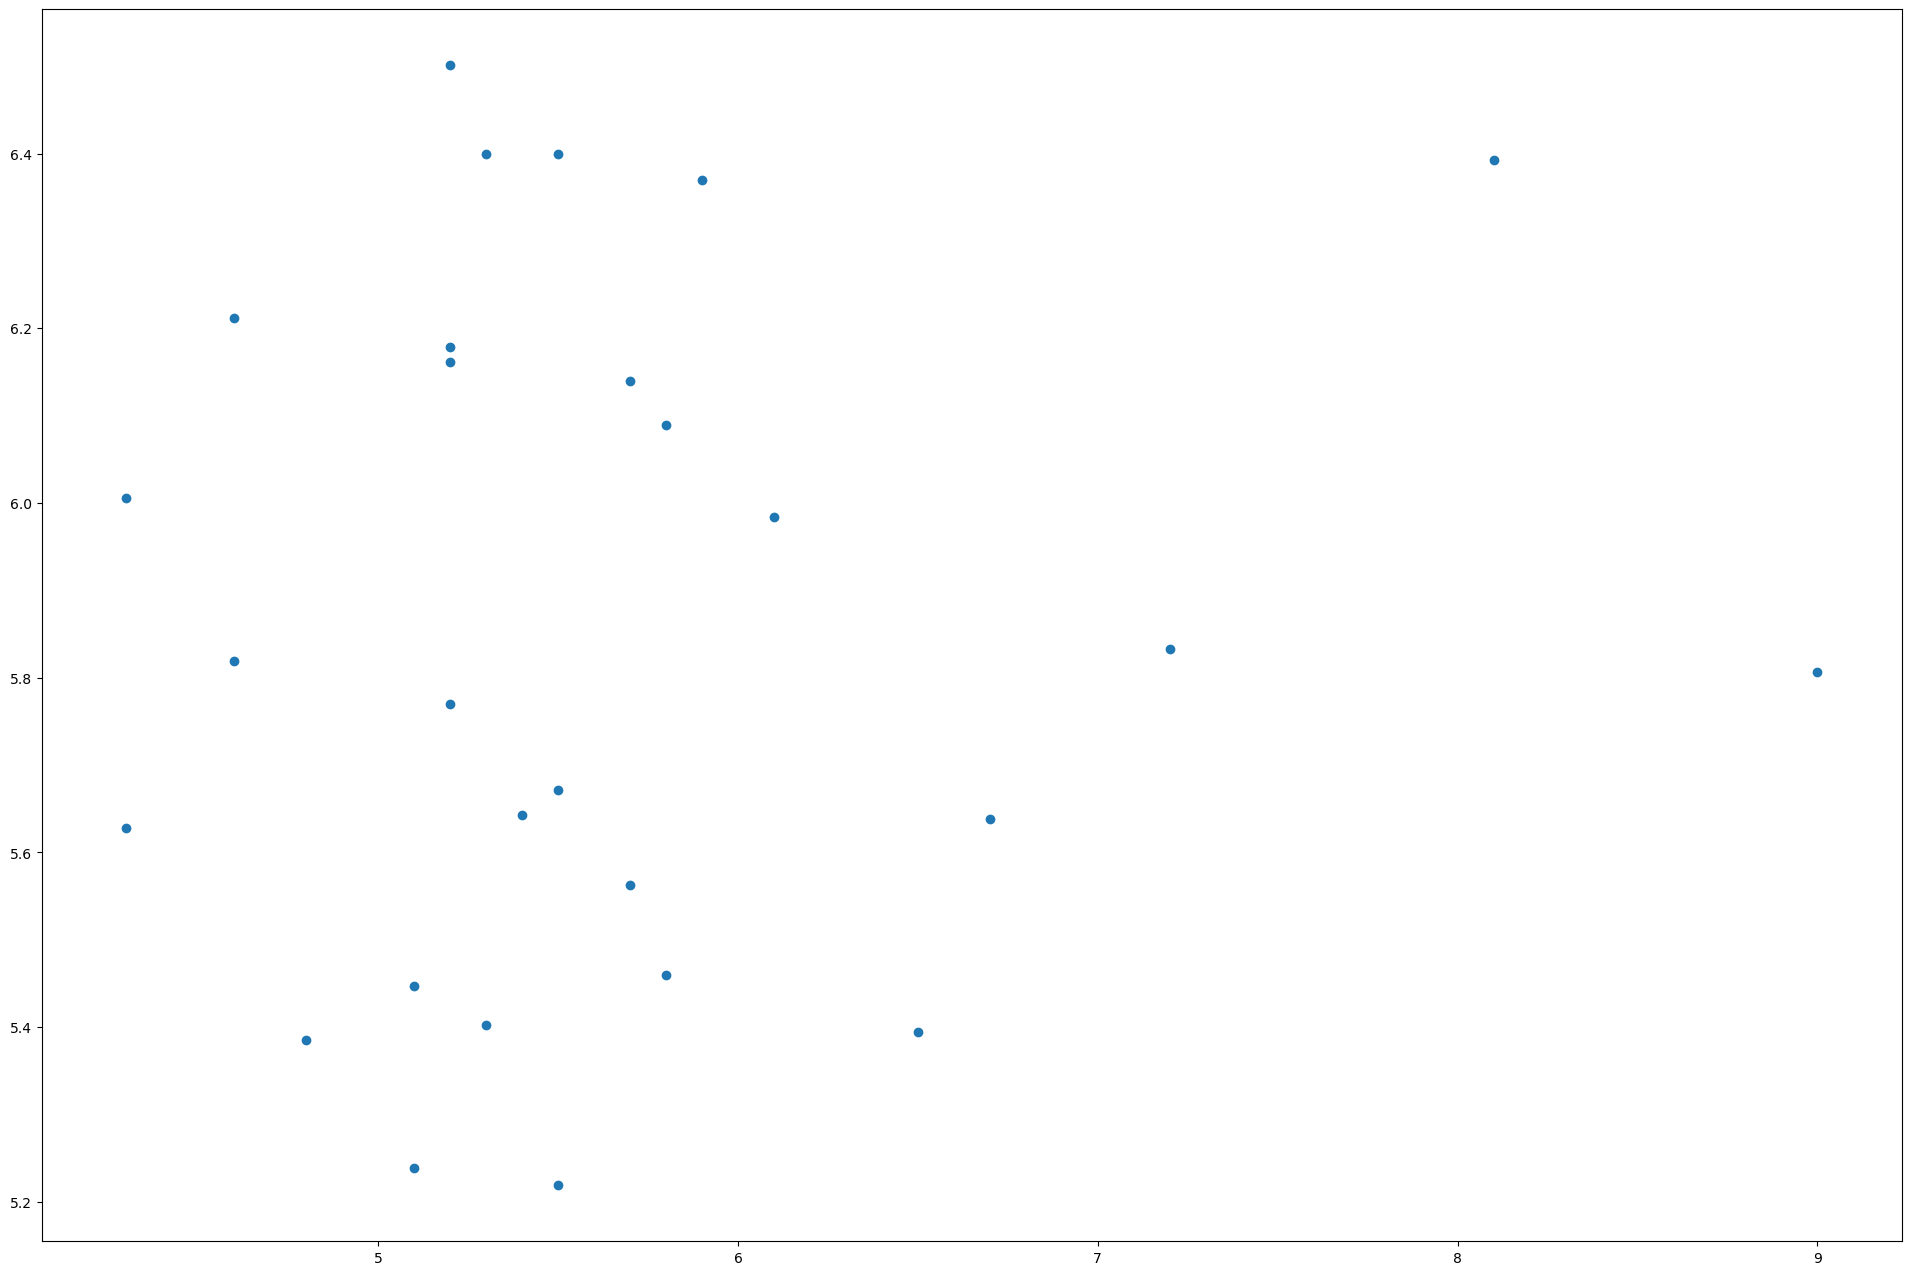

In [106]:
aplt.scatter(y_test,y_hat)

In [125]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")
model.fit(X_train, y_train,)
print(f"Mean Absolute Percentage Error {(scores.mean()*-100):.2f}%")

C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\PC\anaconda3\envs\CA4016\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and wil

Mean Absolute Percentage Error 13.77%


In [126]:
y_hat = model.predict(X_test)
score = mean_absolute_percentage_error(y_test, y_hat)

In [127]:
print(score)

0.16100398182113668
